# a)


128 128 (128, 64, 32, 1) (1, 32, 64, 128)


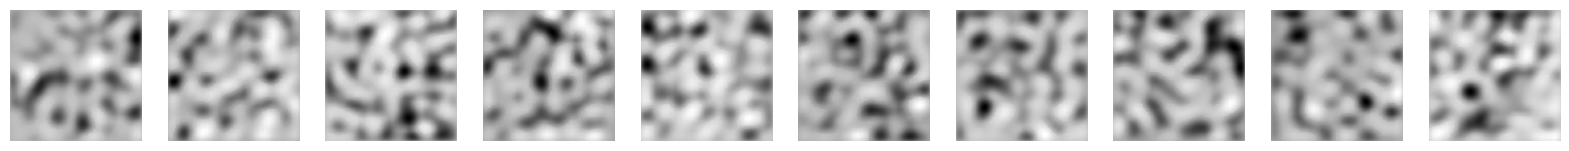

In [4]:
import torch
import matplotlib.pyplot as plt
from deep_generative_models.model_mashood import VAE
from config.paths import STORAGE

MODEL_PATH = STORAGE / "trained_model_VAE_MASHOOD_20241127_194150.pth"
model = VAE(input_dim=128, last_hidden_dim=128, encoder_channels=(1, 32, 64, 128), decoder_channels=(128, 64, 32, 1), device=torch.device("cpu"))
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device("cpu")))
model.eval()

z_samples = torch.randn(10, 128)

generated_images = model.decode(z_samples)

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, img in enumerate(generated_images):
    axes[i].imshow(img.view(128, 128).detach().numpy(), cmap='gray')
    axes[i].axis('off')
plt.show()


The images display plausible images. The only issue is that they are quite blurry. This could be omitted by utilizing a beta VAE or different loss as discussed here: https://ai.stackexchange.com/questions/37272/what-is-an-appropriate-size-for-a-latent-space-of-variational-autoencoders-and

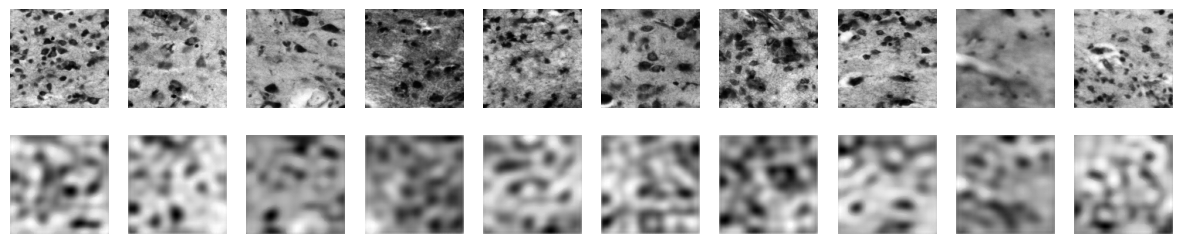

In [5]:
# Load the test data
from config.paths import CELL_DATA
from deep_generative_models.dataset import create_dataloader


test_loader = create_dataloader(CELL_DATA, ["B20"], tile_size=128, batch_size=10, tiles_per_epoch=10, num_workers=0)

# Get a batch of test images
test_images = next(iter(test_loader))

# Reconstruct the images using the VAE
with torch.no_grad():
    reconstructed_images, _, _ = model(test_images)

# Plot the original and reconstructed images
def plot_reconstructed_images(original, reconstructed):
    original = original.view(-1, 128, 128).cpu().numpy()
    reconstructed = reconstructed.view(-1, 128, 128).cpu().numpy()
    fig, axes = plt.subplots(2, len(original), figsize=(15, 3))
    for i in range(len(original)):
        axes[0, i].imshow(original[i], cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed[i], cmap="gray")
        axes[1, i].axis("off")
    plt.show()

plot_reconstructed_images(test_images, reconstructed_images)

# b)

128 128 (128, 64, 32, 1) (1, 32, 64, 128)


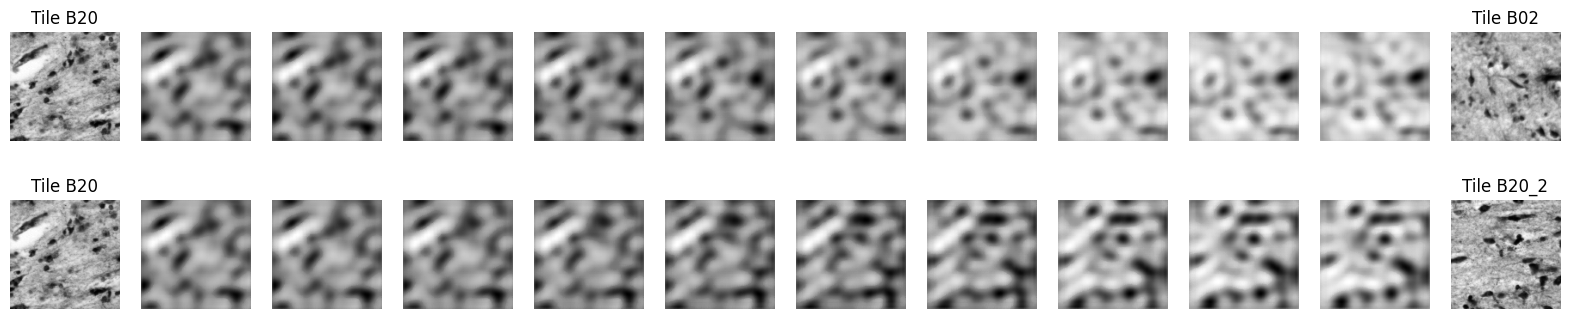

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
MODEL_PATH = STORAGE / "trained_model_VAE_MASHOOD_20241127_194150.pth"
model = VAE(input_dim=128, last_hidden_dim=128, encoder_channels=(1, 32, 64, 128), decoder_channels=(128, 64, 32, 1), device=torch.device("cpu"))
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device("cpu")))
model.eval()

# Load the test data for B20 and B02
test_loader_B20 = create_dataloader(CELL_DATA, ["B20"], tile_size=128, batch_size=1, tiles_per_epoch=3000, num_workers=0)
test_loader_B02 = create_dataloader(CELL_DATA, ["B02"], tile_size=128, batch_size=1, tiles_per_epoch=3000, num_workers=0)

# Get a tile from B20 and B02
tile_B20 = next(iter(test_loader_B20))
tile_B02 = next(iter(test_loader_B02))

_, mean_B20 = model.encode(tile_B20)
_, mean_B02 = model.encode(tile_B02)

# Define k interpolation steps
k = 10
interpolated_z = [mean_B20 + (mean_B02 - mean_B20) * i / (k - 1) for i in range(k)]
interpolated_images = [model.decode(z) for z in interpolated_z]

# Plot original and interpolated images
fig, axes = plt.subplots(2, k + 2, figsize=(20, 4))

axes[0, 0].imshow(tile_B20.view(128, 128).detach().numpy(), cmap='gray')
axes[0, 0].set_title('Tile B20')
axes[0, 0].axis('off')

for i, img in enumerate(interpolated_images):
    axes[0, i + 1].imshow(img.view(128, 128).detach().numpy(), cmap='gray')
    axes[0, i + 1].axis('off')

axes[0, -1].imshow(tile_B02.view(128, 128).detach().numpy(), cmap='gray')
axes[0, -1].set_title('Tile B02')
axes[0, -1].axis('off')

tile_B20_2 = next(iter(test_loader_B20))

# Encode the tiles to obtain their latent representations
_, mean_B20_2 = model.encode(tile_B20_2)

# Define k interpolation steps for within-section
interpolated_z_within = [mean_B20 + (mean_B20_2 - mean_B20) * i / (k - 1) for i in range(k)]

# Decode each interpolated vector for within-section
interpolated_images_within = [model.decode(z) for z in interpolated_z_within]

axes[1, 0].imshow(tile_B20.view(128, 128).detach().numpy(), cmap='gray')
axes[1, 0].set_title('Tile B20')
axes[1, 0].axis('off')

for i, img in enumerate(interpolated_images_within):
    axes[1, i + 1].imshow(img.view(128, 128).detach().numpy(), cmap='gray')
    axes[1, i + 1].axis('off')

axes[1, -1].imshow(tile_B20_2.view(128, 128).detach().numpy(), cmap='gray')
axes[1, -1].set_title('Tile B20_2')
axes[1, -1].axis('off')

plt.show()


The intermediate images gradually blend the structural and textural details of the two tiles, creating a smooth progression. When the tiles are from the same brain section, the transitions appear more natural and consistent because the images share similar features. However, when the tiles come from different sections, the differences in structure and texture are more noticeable, leading to more distinct changes in the interpolated images. While the VAE does a good job capturing and transitioning between features, some of the intermediate images look a bit blurry, suggesting the model struggles to retain fine details. Overall, the process highlights how well the VAE can represent and morph between the features of the tiles, even if it isn’t perfect at preserving all the smaller details.

# C)

/var/folders/4g/91bm8hl51ld9v8c8tg6_lrqw0000gn/T/ipykernel_41105/2692973927.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=z_pca[:, 0], y=z_pca[:, 1], palette="viridis")


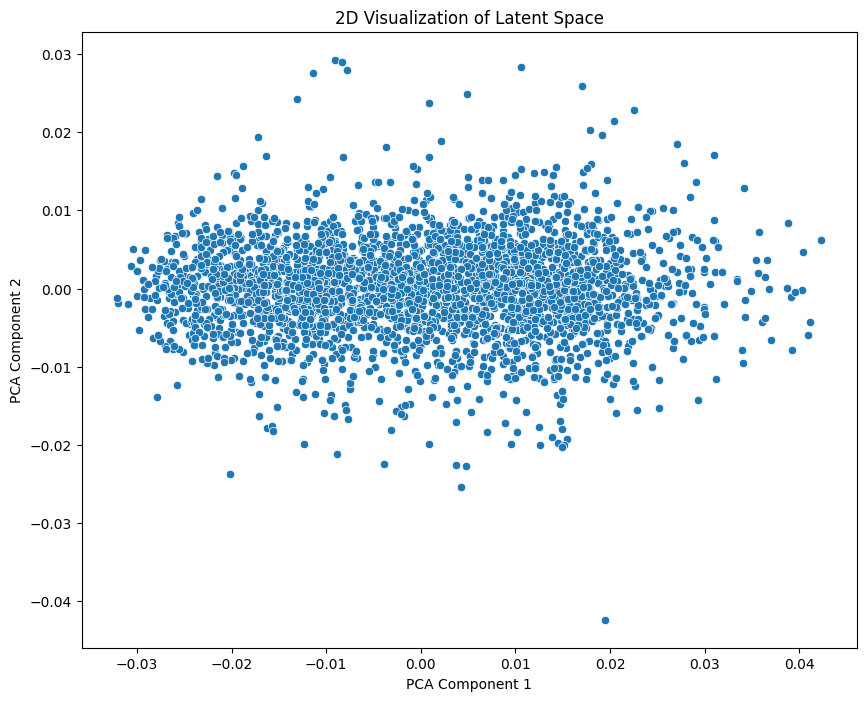

In [7]:
from sklearn.decomposition import PCA
import seaborn as sns
import torch

# Sample ~3,000 tiles
tiles = []
for i, tile in enumerate(test_loader):
    if i >= 3000:
        break
    tiles.append(tile)
tiles = torch.cat(tiles)

var, mean = model.encode(tiles)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(mean.detach().numpy())

# Plot the reduced latent space
plt.figure(figsize=(10, 8))
sns.scatterplot(x=z_pca[:, 0], y=z_pca[:, 1], palette="viridis")
plt.title("2D Visualization of Latent Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


The plot shows a 2D representation of encoded brain tiles after reducing their dimensions using PCA. Most of the data points are tightly clustered around the center, forming a smooth and continuous distribution. This indicates that the Variational Autoencoder (VAE) has learned a compact and consistent representation of the input tiles. There are no clear clusters or gaps, suggesting the tiles share similar features and don't have strong variations or subgroups. Overall, the latent space appears smooth and interpretable, which means the encoder is functioning effectively.